In [ ]:
# проверим видеокарту
!nvidia-smi

Thu Jun 17 20:33:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install fancyimpute
!pip install mlens

  Created wheel for fancyimpute: filename=fancyimpute-0.5.5-cp37-none-any.whl size=26455 sha256=9a5682056e0399e0c0fcab86042f154832fbcacd5dab821cde62446e0319563c
  Stored in directory: /root/.cache/pip/wheels/b2/d2/22/75596186b24b7363894e594f28e98b56fdc56306762bc00fe0
  Created wheel for knnimpute: filename=knnimpute-0.1.0-cp37-none-any.whl size=11354 sha256=e80e5fe56666e62816a68115b02868dc633b1d7d544e536044a39bb3c19a8c1c
  Stored in directory: /root/.cache/pip/wheels/a3/92/31/c3f8864714e9938396c3a68d8c542531f7e2d7862bb750b2e3
Successfully built fancyimpute knnimpute
     |████████████████████████████████| 235kB 4.3MB/s 


# Import libraries and Load Data

In [ ]:
# Игнорируем предупреждения
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils.testing import ignore_warnings
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import timeit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)

from mlens.visualization import corrmat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", color_codes=True)

[MLENS] backend: threading


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузим данные
PATH = "/content/drive/My Drive/datasets/work_data/"
fname = 'Test Sample.xlsx'
df = pd.read_excel(PATH + fname)
display(df)

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.0,Bank,Android,0.0
1,0,2020-12-14,1,3.0,4.0,UMID,32,GMAIL.COM,Other,18000.0,E-wallet,Android,1.0
2,1,2021-01-26,0,0.0,3.0,SSS,41,YAHOO.COM,Private Company Employee,14000.0,Bank,Android,1.0
3,1,2020-12-10,1,0.0,5.0,TIN,28,GMAIL.COM,BPO Professionals,40000.0,E-wallet,Android,1.0
4,1,2021-01-17,0,3.0,3.0,UMID,31,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15358,0,2021-01-05,1,3.0,5.0,UMID,36,GMAIL.COM,Business Owner,25000.0,E-wallet,Android,6.0
15359,1,2021-01-23,1,0.0,3.0,Passport,32,GMAIL.COM,Self-Employed,25000.0,E-wallet,Android,1.0
15360,1,2021-02-01,1,1.0,5.0,UMID,29,GMAIL.COM,Private Company Employee,25000.0,E-wallet,Android,0.0
15361,0,2020-12-14,1,1.0,5.0,UMID,37,GMAIL.COM,Private Company Employee,25000.0,Bank,Android,6.0


In [ ]:
# Проверка датасета на отсутствие данных 
df.isna().sum()

fpd5_flg                    0
dt                          0
gender                      0
device_quaility_index     565
behavioral_index          565
type_of_document            0
age                         0
email_domain_formatted      0
social_status               0
salary                    714
disbursment_type            0
os                         16
email_index                33
dtype: int64

In [ ]:
# Функция для вычисления процентного списка пропущенных данных
def get_persent(fn):
  try:
    for col in fn.columns:
      pct_missing = np.mean(fn[col].isnull())
      print('{} - {}%'.format(col, round(pct_missing*100, 3)))
  except ValueError:
    print('Error DataFrame')

get_persent(df)

fpd5_flg - 0.0%
dt - 0.0%
gender - 0.0%
device_quaility_index - 3.678%
behavioral_index - 3.678%
type_of_document - 0.0%
age - 0.0%
email_domain_formatted - 0.0%
social_status - 0.0%
salary - 4.648%
disbursment_type - 0.0%
os - 0.104%
email_index - 0.215%


In [ ]:
# Выведем описательную статистику по данным
df.describe()

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
count,15363.000000,15363.000000,14798.000000,14798.000000,15363.000000,1.464900e+04,15330.000000
mean,0.272798,0.629109,2.369982,4.051291,35.135781,1.261647e+05,1.580039
std,0.445412,0.483059,1.077686,0.937965,9.125229,1.239332e+07,2.397705
min,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,2.000000,3.000000,28.000000,1.500000e+04,0.000000
50%,0.000000,1.000000,3.000000,4.000000,34.000000,2.000000e+04,1.000000
75%,1.000000,1.000000,3.000000,5.000000,41.000000,2.600000e+04,1.000000
max,1.000000,1.000000,4.000000,6.000000,69.000000,1.500020e+09,12.000000


In [ ]:
# Проверим на дубликаты
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
15358    False
15359    False
15360    False
15361    False
15362    False
Length: 15363, dtype: bool

In [ ]:
# Выведем информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  14649 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [ ]:
# Проверим корреляцию между переменными
df.corr()

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
fpd5_flg,1.000000,-0.059176,-0.063721,0.036196,-0.057321,-0.005169,0.042753
gender,-0.059176,1.000000,-0.072875,-0.021173,-0.002914,0.006323,-0.000178
device_quaility_index,-0.063721,-0.072875,1.000000,-0.030675,-0.229887,-0.010639,-0.076656
behavioral_index,0.036196,-0.021173,-0.030675,1.000000,-0.018614,0.008439,0.036294
age,-0.057321,-0.002914,-0.229887,-0.018614,1.000000,0.005681,0.086435
salary,-0.005169,0.006323,-0.010639,0.008439,0.005681,1.000000,-0.001994
email_index,0.042753,-0.000178,-0.076656,0.036294,0.086435,-0.001994,1.000000


Text(0.5, 1.05, 'Correlation Matrix')

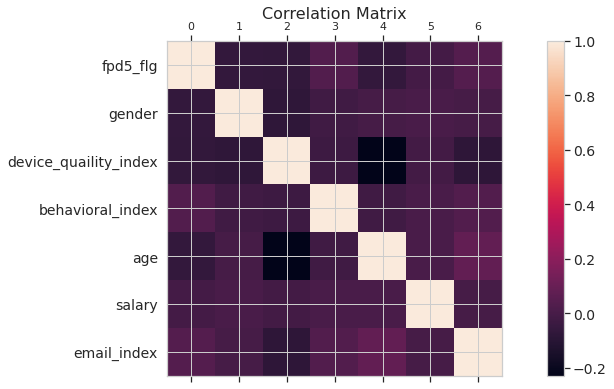

In [ ]:
# Построим матрицу корреляции
f = plt.figure(figsize=(16, 6))
plt.matshow(df.corr(), fignum=f.number)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

По данным выше видно, что пропуски имееются в переменных device_quaility_index, behavioral_index,salary, os, email_index причина отсутствие данных. Корреляция между переменными есть, но слабая. Просто удалить пропуски из переменных было бы не корректно. Чтобы не потерять данные, подставим в пропуски значения.

# Preprocessing Data

In [ ]:
# Получим X и Y c датасета
df1 = df.copy()
X = df1.drop(['fpd5_flg', 'dt'], axis=1).values
Y = df1['fpd5_flg'].astype(int)
col = df1.drop(['fpd5_flg', 'dt'], axis=1)

class_0 = len(df1[df1['fpd5_flg']==0])
class_1 = len(df1[df1['fpd5_flg']==1])
class_0_perc = class_0/(class_0 + class_1)
class_1_perc = class_1 / (class_0 + class_1)

print(f"class_0: {round((class_0_perc * 100), 3)} %")
print(f"class_1: {round((class_1_perc * 100), 3)} %\n")

# Проверим баланс классов
df1.fpd5_flg.value_counts(normalize = True)

class_0: 72.72 %
class_1: 27.28 %



0    0.727202
1    0.272798
Name: fpd5_flg, dtype: float64

In [ ]:
# Заменим пропуски медианной в переменных
df1['dt'] =  pd.to_datetime(df1['dt'], infer_datetime_format=True)
df1['salary'] = df['salary'].fillna(df1['salary']. median()).astype(int)
df1['behavioral_index'] = df1['behavioral_index'].fillna(df1['behavioral_index']. median()).astype(int)
df1['device_quaility_index'] = df1['device_quaility_index'].fillna(df1['device_quaility_index']. median()).astype(int)

# вычислим средние категориальные значения для других категориальных переменных
df1 = pd.get_dummies(df1, columns=['type_of_document', 'disbursment_type', 'os'])
df1['email_index'] = df1['email_index'].fillna(df1['email_index']. median()).astype(int)

# Удаляем тектстовые значения, но можно их было пропустить через токенайзер, получить Embanding и добавить к обшей выборке
df1 = df1.drop(['dt', 'email_domain_formatted', 'social_status'], axis = 1)

# Проверка датасета на отсутствие данных 
df1.isna().sum()

fpd5_flg                              0
gender                                0
device_quaility_index                 0
behavioral_index                      0
age                                   0
salary                                0
email_index                           0
type_of_document_Driver license ID    0
type_of_document_PRC                  0
type_of_document_Passport             0
type_of_document_SSS                  0
type_of_document_TIN                  0
type_of_document_UMID                 0
disbursment_type_Bank                 0
disbursment_type_E-wallet             0
os_Android                            0
os_Chrome OS                          0
os_Linux                              0
os_OS X                               0
os_Windows                            0
os_iOS                                0
os_macOS                              0
dtype: int64

Text(0.5, 1.0, 'Соотношение классов')

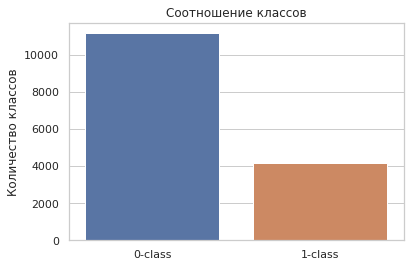

In [ ]:
# Отобразим на графике

pos = df1[df1['fpd5_flg'] == 0].shape[0]
neg = df1[df1['fpd5_flg'] == 1].shape[0]
plt.figure(figsize=(6, 4))
sns.countplot(df1['fpd5_flg'])
plt.xticks((0, 1), ['0-class', "1-class"])
plt.ylabel('Количество классов')
plt.xlabel("")
plt.title('Соотношение классов')

Дисбаланс классов.Для более точной оценке будем использовать, RobustScaler чтобы стандартизация была менее подвержена влиянию выбросов, т.е. была более надежной.

# Make Models

In [ ]:
# Исходные данные
X = df1.loc[:, df1.columns != "fpd5_flg"].values
y = df1.loc[:, df1.columns == "fpd5_flg"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Исходные данные shapes: {X_train.shape, X_test.shape}")
print(f"Исходные данные shapes: {y_train.shape, y_test.shape}")

# Очистка двоичных столбцов
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, y_train_dropna = X_train[~train_indices_na, :][:, :-6], y_train[~train_indices_na]
X_test_dropna, y_test_dropna = X_test[~test_indices_na, :][:, :-6], y_test[~test_indices_na]
print(f"\nОчищенные данные: {X_train_dropna.shape, X_test_dropna.shape}\n")


# Преобразование данных
mice = IterativeImputer(verbose=0)
X_mice = mice.fit_transform(X)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(
    X_mice, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Преобразование данных: {X_train_mice.shape, X_test_mice.shape}")
print(f"Преобразование данных: {y_train_mice.shape, y_test_mice.shape}")


Исходные данные shapes: ((12290, 21), (3073, 21))
Исходные данные shapes: ((12290,), (3073,))

Очищенные данные: ((12290, 15), (3073, 15))

Преобразование данных: ((12290, 21), (3073, 21))
Преобразование данных: ((12290,), (3073,))


In [ ]:
%%timeit

# Модель случайный лес классификатор 
rf_clf = RandomForestClassifier(n_estimators=100,
                                max_features=0.25,
                                criterion="gini",
                                class_weight="balanced")
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"\nБазовая модель средняя AUC: {scores.mean():.3f}\n")

# Модель со среднеми  данными
pip_impute_mean = make_pipeline(SimpleImputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"\nМодель со среднеми данными средняя AUC: {scores.mean():.3f}\n")

# Модель с медианными данными
pip_impute_median = make_pipeline(SimpleImputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"\nМодель с медианными данными средняя AUC: {scores.mean():.3f}\n")


# Модель с преобразованными данными
pip_impute_mice = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mice,
                         X_train_mice, y_train_mice,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"\nМодель с преобразованными данными средняя AUC: {scores.mean():.3f}\n")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Базовая модель средняя AUC: 0.564



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель со среднеми данными средняя AUC: 0.567



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с медианными данными средняя AUC: 0.569



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с преобразованными данными средняя AUC: 0.568



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Базовая модель средняя AUC: 0.564



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель со среднеми данными средняя AUC: 0.569



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с медианными данными средняя AUC: 0.567



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с преобразованными данными средняя AUC: 0.566



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Базовая модель средняя AUC: 0.563



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель со среднеми данными средняя AUC: 0.566



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с медианными данными средняя AUC: 0.566



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с преобразованными данными средняя AUC: 0.566



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Базовая модель средняя AUC: 0.565



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель со среднеми данными средняя AUC: 0.566



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с медианными данными средняя AUC: 0.567



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с преобразованными данными средняя AUC: 0.568



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Базовая модель средняя AUC: 0.564



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель со среднеми данными средняя AUC: 0.569



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с медианными данными средняя AUC: 0.567



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с преобразованными данными средняя AUC: 0.569



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Базовая модель средняя AUC: 0.566



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель со среднеми данными средняя AUC: 0.570



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Модель с медианными данными средняя AUC: 0.568


Модель с преобразованными данными средняя AUC: 0.568

1 loop, best of 5: 43.8 s per loop


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.6s finished


In [ ]:
%%time
# Модель случайного леса классификатор(конфигурация та же)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Модель построенная на средней выборке
pip_orig = make_pipeline(SimpleImputer(strategy="mean"), RobustScaler(),rf_clf)                    
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Модель построенная на средней выборке среднее AUC: {scores.mean():.3f}")

# Модель с Undersampling
pip_undersample = imb_make_pipeline(SimpleImputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Модель с Undersampling средняя AUC: {scores.mean():.3f}")

# модель с передискретизации
pip_oversample = imb_make_pipeline(SimpleImputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"модель с передискретизации средняя AUC: {scores.mean():.3f}")

# Модель с EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(SimpleImputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"модель с EasyEnsemble средняя AUC: {scores.mean():.3f}")

# Модель SMOTE
pip_smote = imb_make_pipeline(SimpleImputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Модель SMOTE: {scores.mean():.3f}")

Модель построенная на средней выборке среднее AUC: 0.569
Модель с Undersampling средняя AUC: 0.573
модель с передискретизации средняя AUC: 0.565
модель с EasyEnsemble средняя AUC: 0.583
Модель SMOTE: 0.568
CPU times: user 11min 51s, sys: 3.93 s, total: 11min 55s
Wall time: 11min 52s


Построим модели, используя три разные модели в качестве базовых 
обучающихся:

Extra Gradient Boosting

Support Vector Classifier

Random Forest

In [ ]:
# Мы будем использовать логистическую регрессию в качестве метаобучения и k-folds cross validation для проверки и настройки гиперпараметров составной модели. 
# Кроме того, мы построим кривые ROC и AUC с использованием тестовых данных и оценим производительность всех моделей

%%time
# Заменем данные на среднее
imp = SimpleImputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Стандартизуем данные
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

# Реализуем RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
# Перемешаем данные
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape


# Extra Gradient Boosting
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

# Support Vector Classifier
svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

#  Random Forest
rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Определитель обучения
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# Установка для голосования CLF
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

# Первый стек
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Используйте CV для создания мета-функций 
meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")
# Второй стек
first_stack.fit(X_res, y_res)
second_stack = logreg_clf.fit(meta_features, y_res)

CPU times: user 3min 14s, sys: 976 ms, total: 3min 15s
Wall time: 3min 15s


# Score Models

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import timeit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)

from mlens.visualization import corrmat

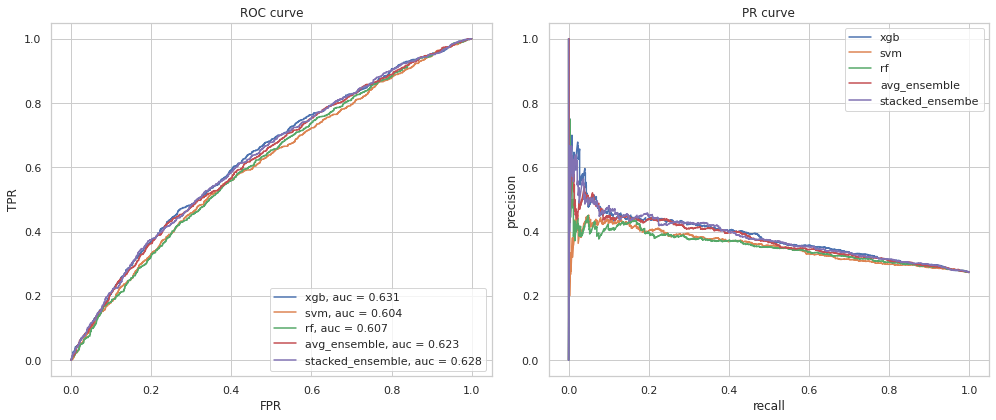

In [ ]:
# Постройте кривые ROC и PR, используя все модели и данные испытаний
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

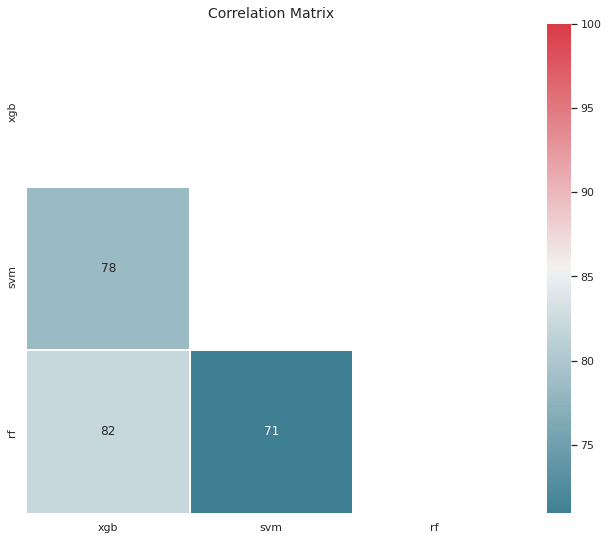

In [ ]:
# Построим матрицу корреляций
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"])
corrmat(probs_df.corr(), inflate=True)

In [ ]:
print(models.keys()) 

dict_keys(['xgb', 'svm', 'rf', 'avg_ensemble'])


In [ ]:
xgb = models['xgb'].predict_proba(X)
svm = models['svm'].predict_proba(X)
rf = models['rf'].predict_proba(X)
avg_ensemble = models['avg_ensemble'].predict_proba(X)
_data = np.concatenate([xgb, svm, rf, avg_ensemble], axis=1)
cols=['0_class_xgb', '1_class_xgb', '0_class_svm', '1_class_svm', '0_class_rf', '1_class_rf', '0_class_avg_ensemble', '1_class_avg_ensemble']
result_data = pd.DataFrame(_data, columns=cols)

result_data



,0_class_xgb,1_class_xgb,0_class_svm,1_class_svm,0_class_rf,1_class_rf,0_class_avg_ensemble,1_class_avg_ensemble
0,0.808152,0.191848,3.000001e-14,1.0,0.696833,0.303167,0.495865,0.504135
1,0.807060,0.192940,3.000001e-14,1.0,0.642573,0.357427,0.481069,0.518931
2,0.795425,0.204575,3.000001e-14,1.0,0.721564,0.278436,0.503789,0.496211
3,0.759248,0.240752,3.000001e-14,1.0,0.633568,0.366432,0.453891,0.546109
4,0.808152,0.191848,3.000001e-14,1.0,0.696833,0.303167,0.495865,0.504135
...,...,...,...,...,...,...,...,...
15358,0.796126,0.203874,3.000001e-14,1.0,0.613315,0.386685,0.459316,0.540684
15359,0.772805,0.227195,3.000001e-14,1.0,0.561966,0.438034,0.444307,0.555693
15360,0.808152,0.191848,3.000001e-14,1.0,0.647206,0.352794,0.479949,0.520051
15361,0.796126,0.203874,3.000001e-14,1.0,0.664772,0.335228,0.482368,0.517632


In [ ]:
res_datе = pd.concat([result_data, df], axis=1)
res_datе.to_excel('/content/res_data.xlsx')